In [1]:
import sys
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score

c:\Users\arvin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = r"C:\Users\arvin\Desktop\python\deep_circum\dataset"
video_files = os.listdir(data_dir)

# Extract labels from filenames
data = []
labels = []

for file in video_files:
    if 'fake' in file:
        label = 1
    else:
        label=0  # Skip files without proper labels

    video_path = os.path.join(data_dir, file)
    data.append(video_path)
    labels.append(label)


Real videos: 49
Fake videos: 49


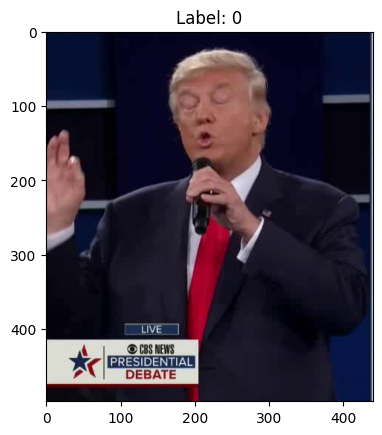

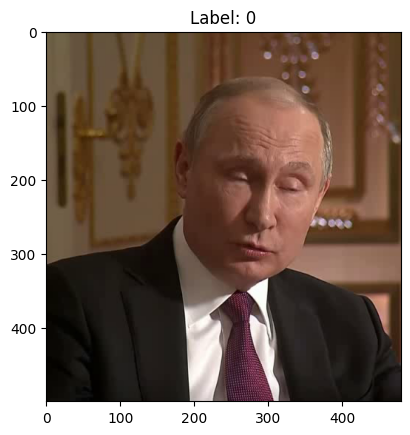

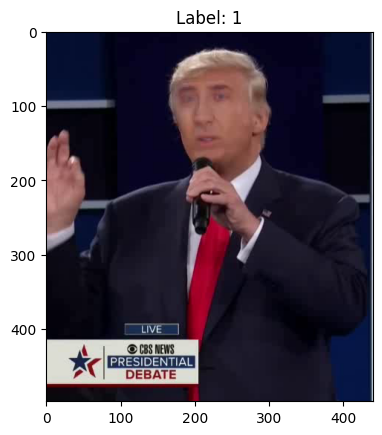

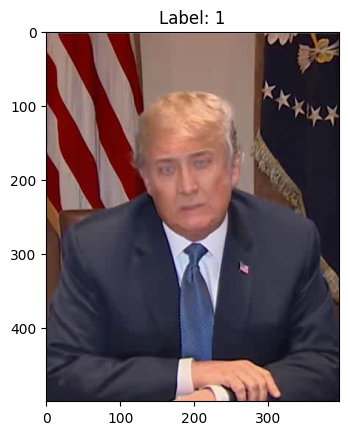

In [3]:
import random

# Display counts of real and fake videos
print(f"Real videos: {labels.count(0)}")
print(f"Fake videos: {labels.count(1)}")

# Visualize some samples
def display_sample_videos(data, labels, label, n=2):
    sample_videos = [data[i] for i in range(len(data)) if labels[i] == label]
    sample_videos = random.sample(sample_videos, n)
    for video_path in sample_videos:
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        if ret:
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title(f"Label: {label}")
            plt.show()
        cap.release()

display_sample_videos(data, labels, 0)  # Display real videos
display_sample_videos(data, labels, 1)  # Display fake videos


In [4]:
def extract_frames(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, frame_count // num_frames)
    for i in range(0, frame_count, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()
    return frames

frame_data = []
frame_labels = []

for i in range(len(data)):
    video_path = data[i]
    label = labels[i]
    frames = extract_frames(video_path)
    frame_data.extend(frames)
    frame_labels.extend([label] * len(frames))

frame_data = np.array(frame_data)
frame_labels = np.array(frame_labels)


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(frame_data, frame_labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")


Train set: (294, 224, 224, 3), (294,)
Validation set: (98, 224, 224, 3), (98,)
Test set: (98, 224, 224, 3), (98,)


In [6]:
class DeepfakeDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(images=[image])['pixel_values'][0]
        return image, torch.tensor(label, dtype=torch.long)

transform = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

train_dataset = DeepfakeDataset(X_train, y_train, transform=transform)
val_dataset = DeepfakeDataset(X_val, y_val, transform=transform)
test_dataset = DeepfakeDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


c:\Users\arvin\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        val_running_loss = 0.0
        all_preds = []
        all_labels = []
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

train_losses, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')

plt.show()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs).logits
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

y_true, y_pred = evaluate_model(model, test_loader)
print(classification_report(y_true, y_pred))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")


              precision    recall  f1-score   support

           0       0.94      0.92      0.93        52
           1       0.91      0.93      0.92        46

    accuracy                           0.93        98
   macro avg       0.93      0.93      0.93        98
weighted avg       0.93      0.93      0.93        98

Accuracy: 0.9286


In [ ]:
torch.save(model.state_dict(), 'vit_deepfake_model.pth')
